In [1]:
import pandas as pd
import numpy as np
from pymongo import MongoClient
client = MongoClient('localhost', 27017)
import pprint
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [2]:
# import apartment info from mongodb
db = client['apartments']
table = db['main_pages']

In [3]:
table.count_documents({})

586

In [4]:
apartment_collection = table.find()

In [5]:
#create new dataframe with just headers
df_columns = ['listing_id', 'property_name', 'address', 'mean_rent', 'mean_area', 'walkscore']
df = pd.DataFrame(columns=df_columns)

In [6]:
# for each apartment in collection parse html and 
# find the following info in collection 
# [name, address, price or price range, area, and Walkscore] 
# and add to Pandas DF
for apartment in apartment_collection:
    soup = BeautifulSoup(apartment['html'], 'html.parser')
    
    listing_id = apartment['listing_id']
    property_name = soup.find('h1', 'propertyName').text.strip()
    address_ = soup.find('div', 'propertyAddress').find('h2').text
    address = ' '.join(address_.split())
    
    # iterate through each unit and find mean price and area
    max_rents = []
    unit_areas = []
    for unit in soup.find('table', 'availabilityTable').find('tbody').find_all('tr', 'rentalGridRow'):
        availability = unit.find('td', 'available').text.strip()
        # only look at max rents for simplicity
        unit_max_rent = unit['data-maxrent']
        if (availability == 'Available Now') and (unit_max_rent != ''):
            max_rents.append(int(unit_max_rent))
        else:
            break
        unit_area_str = unit.find('td', 'sqft').text.strip(' Sq Ft')
        unit_area_range = unit_area_str.replace(',', '').split(' - ')
        
    mean_rent = 0
    mean_area = 0
    try:
        mean_rent = sum(max_rents) / len(max_rents)
    except:
        print('Rent problem: {}'.format(address))
        
    try:
        unit_area_range = [int(area) for area in unit_area_range]
        unit_area = (max(unit_area_range) + min(unit_area_range)) / 2
        unit_areas.append(unit_area)
        mean_area = sum(unit_areas) / len(unit_areas)
    except:
        print('area problem: {}'.format(address))
        
    
    walkscore = 1
    
    #add info to DF
    row = pd.DataFrame([[listing_id, 
                         property_name, 
                         address, 
                         mean_rent, 
                         mean_area, 
                         walkscore]], columns=df_columns)
    df = df.append(row, ignore_index=True)
    
    

Rent problem: 2704 Rio Grande St, Austin, TX 78705
Rent problem: 110 San Antonio St, Austin, TX 78701
Rent problem: 2810 Hemphill Park, Austin, TX 78705
Rent problem: 2815 Guadalupe St, Austin, TX 78705
Rent problem: 13005 Heinemann Dr, Austin, TX 78727
Rent problem: 1600 Wickersham Ln, Austin, TX 78741
Rent problem: 1300 Crossing Pl, Austin, TX 78741
Rent problem: 1833 Cheddar Loop, Austin, TX 78728
Rent problem: 1301 Crossing Pl, Austin, TX 78741
Rent problem: 1901 Mariposa Dr, Austin, TX 78741
Rent problem: 1500 E Riverside Dr, Austin, TX 78741
Rent problem: 5501 Ross Rd, Del Valle, TX 78617
Rent problem: 507 W 23rd St, Austin, TX 78705
Rent problem: 1114 Camino La Costa, Austin, TX 78752
Rent problem: 3603 Southridge Dr, Austin, TX 78704
Rent problem: 1801 Wells Branch Pky, Austin, TX 78728
Rent problem: 2101 Rio Grande, Austin, TX 78705
Rent problem: 400 W Anderson Ln, Austin, TX 78752
Rent problem: 615 Wonsley Dr E, Austin, TX 78753
Rent problem: 1016 Camino La Costa, Austin, TX 

In [10]:
df

,listing_id,property_name,address,mean_rent,mean_area,walkscore
0,p9c5ygt,Dobie Twenty21 Student Spaces,"2021-2025 Guadalupe St, Austin, TX 78705",1791.500000,792.0,1
1,rdsyjd0,The District on La Frontera,"2811 La Frontera Blvd, Austin, TX 78728",2130.714286,1232.0,1
2,vsvz28g,Cliffs at Barton Creek,"3050 Tamarron Blvd, Austin, TX 78746",2585.545455,1392.0,1
3,pfzryrs,Radius On Grove,"2301 Grove Blvd, Austin, TX 78741",1604.000000,1298.0,1
4,lb7xscf,Chandelier,"2336 Douglas St, Austin, TX 78741",1274.333333,892.0,1
...,...,...,...,...,...,...
581,zspjkkx,Altis Lakeline,"12700 Ridgeline Blvd, Cedar Park, TX 78613",0.000000,1086.0,1
582,l8esygf,300 Bowie St Unit 2904,"Austin, TX 78703",1995.000000,565.0,1
583,w4ex40j,617 Peacock Ln,"Austin, TX 78704",2950.000000,1766.0,1
584,6vvhrpr,6500 Adair Dr,"Austin, TX 78754",1650.000000,1636.0,1


In [7]:
df[df['mean_rent'] != 0]

,listing_id,property_name,address,mean_rent,mean_area,walkscore
0,p9c5ygt,Dobie Twenty21 Student Spaces,"2021-2025 Guadalupe St, Austin, TX 78705",1791.500000,792.0,1
1,rdsyjd0,The District on La Frontera,"2811 La Frontera Blvd, Austin, TX 78728",2130.714286,1232.0,1
2,vsvz28g,Cliffs at Barton Creek,"3050 Tamarron Blvd, Austin, TX 78746",2585.545455,1392.0,1
3,pfzryrs,Radius On Grove,"2301 Grove Blvd, Austin, TX 78741",1604.000000,1298.0,1
4,lb7xscf,Chandelier,"2336 Douglas St, Austin, TX 78741",1274.333333,892.0,1
...,...,...,...,...,...,...
580,h9z6sd3,La Frontera Square Apartments,"2601 La Frontera Blvd, Round Rock, TX 78681",1141.000000,1086.0,1
582,l8esygf,300 Bowie St Unit 2904,"Austin, TX 78703",1995.000000,565.0,1
583,w4ex40j,617 Peacock Ln,"Austin, TX 78704",2950.000000,1766.0,1
584,6vvhrpr,6500 Adair Dr,"Austin, TX 78754",1650.000000,1636.0,1


(array([97.,  0.,  0.,  0., 10., 45., 60., 80., 74., 53., 44., 33., 19.,
        14., 14., 11.,  8.,  4.,  2.,  2.,  5.,  2.,  1.,  3.,  0.,  0.,
         2.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([   0.        ,  183.57636364,  367.15272727,  550.72909091,
         734.30545455,  917.88181818, 1101.45818182, 1285.03454545,
        1468.61090909, 1652.18727273, 1835.76363636, 2019.34      ,
        2202.91636364, 2386.49272727, 2570.06909091, 2753.64545455,
        2937.22181818, 3120.79818182, 3304.37454545, 3487.95090909,
        3671.52727273, 3855.10363636, 4038.68      , 4222.25636364,
        4405.83272727, 4589.40909091, 4772.98545455, 4956.56181818,
        5140.13818182, 5323.71454545, 5507.29090909, 5690.86727273,
        5874.44363636, 6058.02      , 6241.59636364, 6425.17272727,
        6608.74909091, 6792.32545455, 6975.90181818, 7159.47818182,
        7343.05454545, 7526.63090909

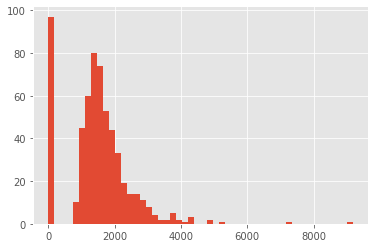

In [8]:
y = df['mean_rent']
plt.hist(df['mean_rent'], bins=50)

In [9]:
# Create column for cost/SF

# Create column for some metric comparing cost/SF and Walkscore. 
# Maybe it's the ((cost/SF) / Walkscore)